# Iris Experiment

This notebook replicates Figure 2

In [1]:
# To test different hyperparamter combinations, you can add options here
hp_options = {
    'default' : {'CNF' : False, 'alpha' : 0.90},
}

this_hp_set = 'default'

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
sys.path.append('../..')
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, datasets
from sklearn.neighbors import KernelDensity
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, precision_recall_curve, accuracy_score
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.rc('font', family='Serif', size=16)

import graphviz 
from overrule.overrule import OverRule2Stage
from overrule.baselines import knn, marginal, propscore, svm, maxbox
from overrule.support import SVMSupportEstimator, SupportEstimator
from overrule.overlap import SupportOverlapEstimator
from overrule.ruleset import BCSRulesetEstimator, RulesetEstimator

In [3]:
os.makedirs('./results/exp_iris-{}'.format(this_hp_set), exist_ok=True)

iris = datasets.load_iris()

f_cols = ['Sepal length', 'Sepal width']#, 'Petal length', 'Petal width']
D = pd.DataFrame(iris['data'][:,:2], columns=f_cols)
y = iris['target']
D['class'] = y
yg = y.copy()-1
yg[yg<0] = 2
D['group'] = yg
Dg = D.loc[D['group']<2,:].copy()
Dg.head()

,Sepal length,Sepal width,class,group
50,7.0,3.2,1,0
51,6.4,3.2,1,0
52,6.9,3.1,1,0
53,5.5,2.3,1,0
54,6.5,2.8,1,0


In [4]:
np.random.seed(0)
RS_s = BCSRulesetEstimator(
    # This is the only change
    alpha=hp_options[this_hp_set]['alpha'], 
    CNF=hp_options[this_hp_set]['CNF'], 
    # These are the same as before
    gamma=0, n_ref_multiplier=1., 
    lambda0=2e-2, lambda1=0., cat_cols=[],
    num_thresh=12, solver='ECOS', iterMax=12, B=5) 


#B = propscore.PropensityOverlapEstimator(threshold=.1)
exp_label = 'knn'
B = knn.KNNOverlapEstimator(k=8)
RS_b = BCSRulesetEstimator(n_ref_multiplier=0., alpha=.9, hamming=True, gamma=1.,
                         lambda0=1e-2, lambda1=0., cat_cols=[],
                         num_thresh=12, solver='ECOS', iterMax=15) 
 
O = OverRule2Stage(B, RS_b, RS_s)
O.fit(Dg[f_cols], Dg['group'])

b = B.predict(Dg[f_cols])
MB = maxbox.MaxBoxRulesetEstimator()
MB.fit(Dg[f_cols], b)

R_s, R_b = O.rules(as_str=False)
print(R_s)

[[('Sepal length', '>', 5.5), ('Sepal width', '<=', 3.3), ('Sepal width', '>', 2.6846153846153844)], [('Sepal length', '<=', 6.3), ('Sepal width', '<=', 2.7)]]


In [5]:
plot_CNF_support = hp_options[this_hp_set]['CNF']

## Aside: Reading CNF rules

The default parameters used in this notebook are DNF rules, but if you decide to explore using CNF rules, we make a note on how to read them.

The support rules for CNF are printed as DNF rules for classifying the complement of the support.  That is, you have to read them as a negation of 

(L1 and L2) OR (L3 or L4) ...

Which gives you

not (L1 and L2) AND not (L3 and L4)

The difference is that in the former, you take the patches and look at their union (i.e., if you are covered by any patch, you are included) whereas in the CNF case, you take the patches and look at the complement of the union (i.e., if you are covered by any patch, you are excluded)

In [6]:
def get_patches(R, x0min, x0max, x1min, x1max):
    ps = []
    for k in R:
        x0l = x0min
        x0u = x0max
        x1l = x1min
        x1u = x1max
        for a in k:
            if a[0] == f1 and a[1] == '>':
                x0l = a[2]
            if a[0] == f1 and a[1] == '<=':
                x0u = a[2]
            if a[0] == f2 and a[1] == '>':
                x1l = a[2]
            if a[0] == f2 and a[1] == '<=':
                x1u = a[2]
        ps.append([x0l,x0u,x1l,x1u])
    return ps

    
f1 = f_cols[0]
f2 = f_cols[1]

rss = get_patches(R_s, Dg[f1].min(), Dg[f1].max(), Dg[f2].min(), Dg[f2].max())
rbs = get_patches(R_b, Dg[f1].min(), Dg[f1].max(), Dg[f2].min(), Dg[f2].max())

x0s, x1s = [Dg[f1].min(), Dg[f1].max()], [Dg[f2].min(), Dg[f2].max()]
for v in rss + rbs:
    x0s.append(v[0])
    x0s.append(v[1])
    x1s.append(v[2])
    x1s.append(v[3])
x0s = np.sort(np.unique(x0s))
x1s = np.sort(np.unique(x1s))

ps = []
for i in range(len(x0s)-1):
    for j in range(len(x1s)-1):
        c = [(x0s[i+1]+x0s[i])/2, (x1s[j+1]+x1s[j])/2]
        # in CNF_support, you are included unless excluded by a patch!
        covered_s = True if plot_CNF_support else False 
        for r in rss:
            if c[0]>=r[0] and c[0]<=r[1] and c[1]>=r[2] and c[1]<=r[3]:
                covered_s = False if plot_CNF_support else True 
                break
        covered_b = False
        for r in rbs:
            if c[0]>=r[0] and c[0]<=r[1] and c[1]>=r[2] and c[1]<=r[3]:
                covered_b = True
                break
        covered = covered_s*covered_b
        if covered:
            ps.append([x0s[i],x0s[i+1],x1s[j],x1s[j+1]])
          

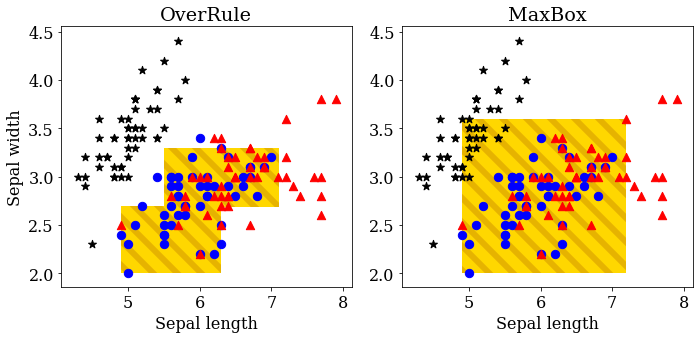

In [7]:
exp_label = 'knn'
cs = ['b','r','k']
ms = ['o','^','*']
plt.rc('font', family='Serif', size=16)
plt.rcParams["hatch.linewidth"] = 6

fs = 5

fig, axs = plt.subplots(1,2,figsize=(2*fs,fs))
ecolor = (.9,.7,.0)

ax = axs[0]
for k in range(len(cs)):
    I = D['group']==k
    ax.scatter(D[I][f_cols[0]], D[I][f_cols[1]], c=cs[k], zorder=2, marker=ms[k], s=70)
    
#plt.scatter(Dg.iloc[b==1][f1], Dg.iloc[b==1][f2], edgecolors='k', s=200, alpha=1., facecolors='none')
for k in ps:
    x0l = k[0]
    x0u = k[1]
    x1l = k[2]
    x1u = k[3]

    color = 'gold'
    rect = patches.Rectangle((x0l,x1l),x0u-x0l,x1u-x1l,linewidth=0, hatch='\\',
                             edgecolor=ecolor, facecolor=color, alpha=1., zorder=-4)
    ax.add_patch(rect)
    ax.set_title('OverRule')
    
    
ax = axs[1]
for k in range(len(cs)):
    I = D['group']==k
    ax.scatter(D[I][f_cols[0]], D[I][f_cols[1]], c=cs[k], zorder=2, marker=ms[k], s=70)
      
MBks = [[MB.rules().loc[f1,'>='],MB.rules().loc[f1,'<='],MB.rules().loc[f2,'>='],MB.rules().loc[f2,'<=']]]
for k in MBks:
    x0l = k[0]
    x0u = k[1]
    x1l = k[2]
    x1u = k[3]

    color = 'gold'
    rect = patches.Rectangle((x0l,x1l),x0u-x0l,x1u-x1l,linewidth=0, hatch='\\',
                             edgecolor=ecolor, facecolor=color, alpha=1, zorder=-4)
    ax.add_patch(rect)
    ax.set_title('MaxBox')

axs[0].set_xlabel(f1)
axs[1].set_xlabel(f1)
axs[0].set_ylabel(f2)

plt.tight_layout()
file_name = 'iris_2d_{}-{}.pdf'.format(exp_label, this_hp_set)
plt.savefig('./results/exp_iris-{}/{}'.format(this_hp_set, file_name))